In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy import stats
from numpy import genfromtxt
from scipy.integrate import quad
import matplotlib.ticker as mtick
import scipy
import pickle

from plotnine.data import economics
from plotnine import *


In [2]:
projPath = '/Users/MegGarr/Documents/SISkappa/data/out/'

In [92]:
def lgm(x):
    return scipy.special.loggamma(x)
# calculate KL divergence between two discrete pmfs
def KLDIV(P,Q):
    totlength = len(P)+1
    kldiv_vec = np.zeros(totlength)
    j=0
    for i in P:
        if i!=0 and Q[j]!=0:
            kldiv_vec[j] = i * (np.log(i) - np.log(Q[j]))
        else:
            kldiv_vec[j] = 0
        j+=1
    return kldiv_vec.sum()


# Make pmf from observation data
def make_pmf(inf_dat):
    n_obs = inf_dat.shape[0] # total number of observations
    maxI = inf_dat.max() # largets I-value observed
    count_I = np.zeros(int(maxI)+1) # make count vector for 0-maxI
    pmf_I = np.zeros(int(maxI)+1) # make pmf vector for 0-maxI
    for i in range(int(maxI)+1):
        count_I[i] = (inf_dat==float(i)).sum()
        pmf_I[i] = count_I[i] / n_obs
    return pmf_I


# Make SISk pmf / pdf
def SISk_pmf(I,κ,Npop):
    def SISk_pdf_u(I,param):
        mu, beta, kappa, gam, N = param
        I = np.array(I)
        pi0 = 1 # will normalize below
        log_density = lgm(N+1) + lgm(N*kappa/beta + I) + I * np.log(beta / ((mu+gam+kappa)*N)) - lgm(N-I+1) - lgm(N*kappa/beta) - lgm(I+1)
#         print(log_density)
        return np.exp(log_density)

    param = np.array([5e-5, 0.5, κ, 1, Npop])

    def SISk_pdf_unnorm(I):
        return SISk_pdf_u(I,param)

    AUC = quad(SISk_pdf_unnorm,0,I.max()+10)
    pynot = AUC[0]
    def SISk_pdf(I):
        return SISk_pdf_unnorm(I) / pynot

    def SISk_pmf_u(I):
        maxI = max(I)+1
        AUC_I = np.zeros(int(maxI))
        for i in range(int(maxI)):
            AUC_I[i] = quad(SISk_pdf,i,i+1)[0]
        return AUC_I
    return SISk_pmf_u(I)


# Make SISk pmf / pdf
def SISk_pdf(I,κ,Npop):
    def SISk_pdf_u(I,param):
        mu, beta, kappa, gam, N = param
        I = np.array(I)
        pi0 = 1 # will normalize below
        log_density = lgm(N+1) + lgm(N*kappa/beta + I) + I * np.log(beta / ((mu+gam+kappa)*N)) - lgm(N-I+1) - lgm(N*kappa/beta) - lgm(I+1)
#         print(log_density)
        return np.exp(log_density)

    param = np.array([5e-5, 0.5, κ, 1, Npop])

    def SISk_pdf_unnorm(I):
        return SISk_pdf_u(I,param)

#     AUC = quad(SISk_pdf_unnorm,0,np.inf)
    AUC = quad(SISk_pdf_unnorm,0,I.max()+10)
    pynot = AUC[0]
    def SISk_pdf(I):
        return SISk_pdf_unnorm(I) / pynot

    return SISk_pdf(I)


def plotPDF(I,κ,Npop):
    pmf_u = SISk_pmf(I,κ,Npop)
    plt.plot(pmf_u)

    
def genFlName(mdl_name, kappa_val, N_val):
    kappa = kappa_val
    ku = "%.3E" % kappa
    ku = ku.replace(".","p")
    ku = ku.replace("-","m")
    ku = ku.replace("+","")

    N = N_val
    Nu = "%.3E" % N
    Nu = Nu.replace(".","p")
    Nu = Nu.replace("-","m")
    Nu = Nu.replace("+","")

    flname = mdl_name + 'k_keq_' + ku + '_Neq_' +  Nu
    return flname

# Lists for loading specific kappa/N pairs

In [105]:
def load_pdf_data(mdl_name,kappa_list,N_list):
#     n_kappa = len(np.array(np.atleast_1d(kappa_list)))
#     n_pop = len(np.array(np.atleast_1d(N_list)))
    n_kappa = len(kappa_list)
    n_pop = len(N_list)
    k_val_vec = np.zeros(n_kappa)
    N_val_vec = np.zeros(n_pop)
        
    df_list = list()
    facet_id = 1
    for i in range(n_kappa):
        for j in range(n_pop):
            # Make strings for file names
            kappa = kappa_list[i]
            ku = "%.3E" % kappa
            ku = ku.replace(".","p")
            ku = ku.replace("-","m")
            ku = ku.replace("+","")

            N = N_list[j]
            Nu = "%.3E" % N
            Nu = Nu.replace(".","p")
            Nu = Nu.replace("-","m")
            Nu = Nu.replace("+","")            
            
            # Organize dataframe for pdf
            I_dfutility = np.linspace(0.1,50,501)
            kappa_dfutility = [ku]*len(I_dfutility)
            N_dfutility = [Nu]*len(I_dfutility)
            name_string_util = [mdl_name]*len(I_dfutility)
            pmf_u = SISk_pdf(I_dfutility,
                             kappa,
                             N)
            facet_dfutility = np.repeat(facet_id,len(I_dfutility))
            invasion_pressure = np.repeat(kappa*N,len(I_dfutility))
            
            
            pmf_df = pd.DataFrame(zip(I_dfutility,
                                      pmf_u,
                                      name_string_util,
                                      kappa_dfutility,
                                      N_dfutility,
                                      facet_dfutility,
                                      invasion_pressure
                                      ),
                                  columns=['Infectious',
                                           'Probability',
                                           'Model Name',
                                           'kappa',
                                           'N',
                                           'Facet ID',
                                           'InvasionPressure'])
            df_list.append(pmf_df)
            facet_id+=1
            
    return pd.concat(df_list)






def load_hist_data(mdl_name,kappa_list,N_list):
    n_kappa = len(kappa_list)
    n_pop = len(N_list)
    k_val_vec = np.zeros(n_kappa)
    N_val_vec = np.zeros(n_pop)
        
    df_list = list()
    facet_id = 1
    for i in range(n_kappa):
        for j in range(n_pop):
            # Make strings for file names
            kappa = kappa_list[i]
            ku = "%.3E" % kappa
            ku = ku.replace(".","p")
            ku = ku.replace("-","m")
            ku = ku.replace("+","")

            N = N_list[j]
            Nu = "%.3E" % N
            Nu = Nu.replace(".","p")
            Nu = Nu.replace("-","m")
            Nu = Nu.replace("+","")

            flname = mdl_name + 'k_keq_' + ku + '_Neq_' +  Nu
            # load the sim-data
            simdat = genfromtxt('/Users/MegGarr/Documents/SISkappa/data/out/' +
                                mdl_name + '/' + flname, delimiter=',')

            # Organize dataframe for pdf
            I_dfutility = np.array(simdat[:,1]) #*#*#*#*# note the difference here from previous function
            df_len = len(I_dfutility)
            kappa_dfutility = [ku]*df_len
            N_dfutility = [Nu]*df_len
            name_string_util = [mdl_name]*df_len
            facet_dfutility = np.repeat(facet_id,df_len)
            
            
            invasion_pressure = np.repeat(kappa*N,df_len)
            if (invasion_pressure[0] > 2.0):
                Pressure = "high"
            elif (invasion_pressure[0] > 0.3):
                Pressure = "med"
            elif (invasion_pressure[0] > 0):
                Pressure = "low"
            Pressure_Level = [Pressure]*df_len
            
            
            pmf_df = pd.DataFrame(zip(I_dfutility,
                                      name_string_util,
                                      kappa_dfutility,
                                      N_dfutility,
                                      facet_dfutility,
                                      invasion_pressure,
                                      Pressure_Level
                                      ),
                                  columns=['Infectious',
                                           'Model Name',
                                           'kappa',
                                           'N',
                                           'Facet ID',
                                           'InvasionPressure',
                                           'Pressure Level'])
            df_list.append(pmf_df)
            facet_id+=1
            
    return pd.concat(df_list)

In [106]:
# make sample list of kappa values
kappa_list = 10.0 ** (np.linspace(-7,-4,30))
# make sample list of N values
N_list = 10.0 ** (np.linspace(2,5,30))

kappa_val = kappa_list[[15,23,29]]
N_val = N_list[[20,25,29]]

# print(kappa_val)
# print(N_val)

pmf_df = load_pdf_data('SI',kappa_val,N_val)
hist_df = load_hist_data('SI',kappa_val,N_val)

{0.9236708571873865, 0.3562247890262444, 0.1373823795883264, 0.2807216203941176, 2.395026619987486, 1.1721022975334794, 3.8566204211634725, 10.0, 0.04175318936560401}


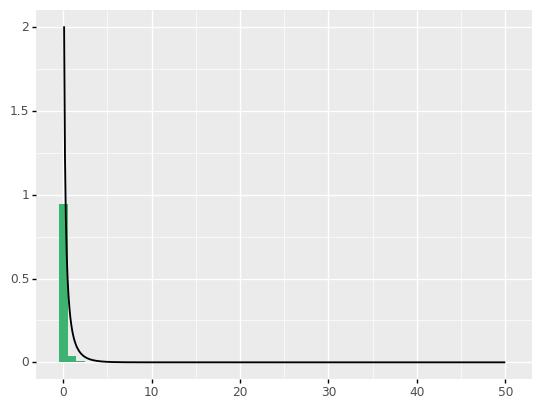

<ggplot: (8794950554853)>
PDF_Hist_1.pdf


/Users/MegGarr/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/MegGarr/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: PDF_Hist_1.pdf


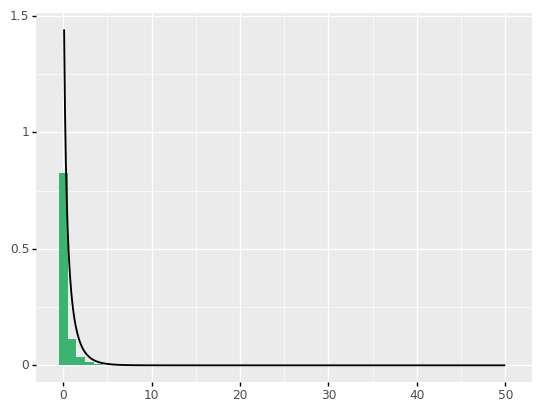

<ggplot: (8794955099109)>
PDF_Hist_2.pdf


/Users/MegGarr/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/MegGarr/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: PDF_Hist_2.pdf


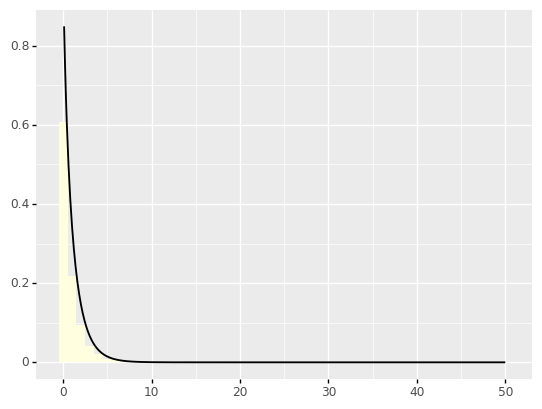

<ggplot: (8794960582769)>
PDF_Hist_3.pdf


/Users/MegGarr/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/MegGarr/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: PDF_Hist_3.pdf


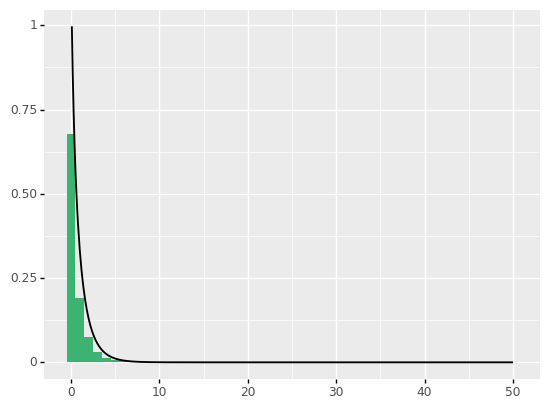

<ggplot: (8794938140777)>
PDF_Hist_4.pdf


/Users/MegGarr/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/MegGarr/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: PDF_Hist_4.pdf


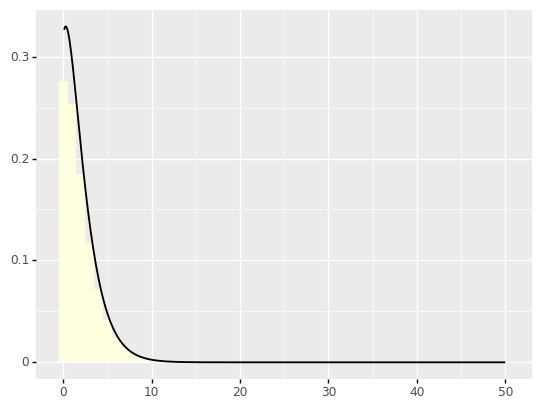

<ggplot: (8794960247993)>
PDF_Hist_5.pdf


/Users/MegGarr/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/MegGarr/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: PDF_Hist_5.pdf


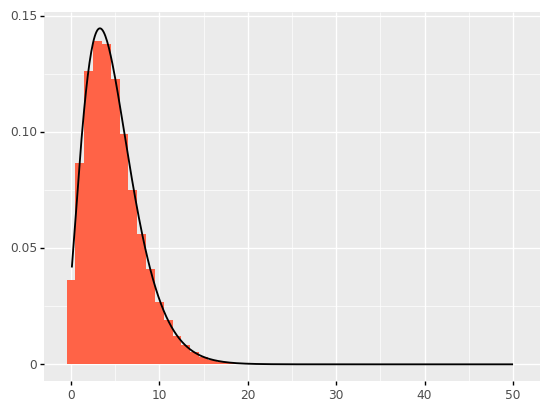

<ggplot: (8794955232873)>
PDF_Hist_6.pdf


/Users/MegGarr/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/MegGarr/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: PDF_Hist_6.pdf


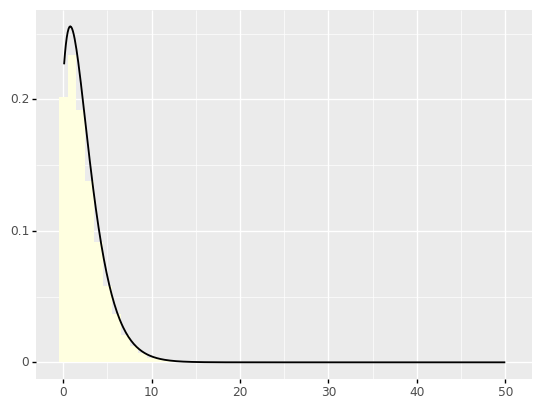

<ggplot: (8794960146729)>
PDF_Hist_7.pdf


/Users/MegGarr/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/MegGarr/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: PDF_Hist_7.pdf


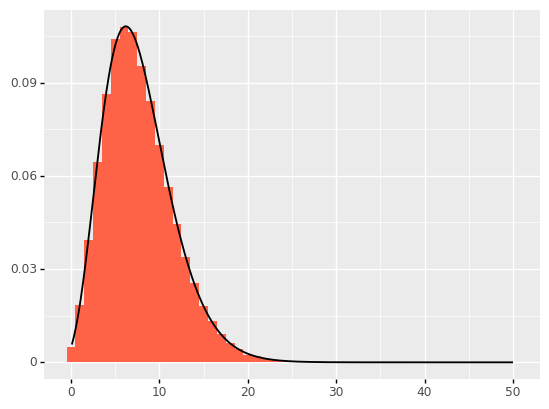

<ggplot: (8794950840741)>
PDF_Hist_8.pdf


/Users/MegGarr/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/MegGarr/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: PDF_Hist_8.pdf


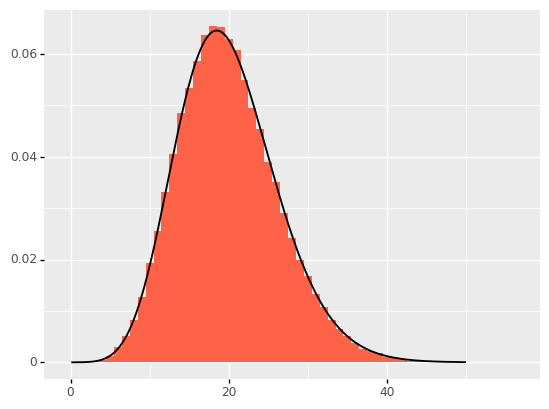

<ggplot: (8794960146729)>
PDF_Hist_9.pdf


/Users/MegGarr/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/MegGarr/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: PDF_Hist_9.pdf


In [109]:
print(set(pmf_df['InvasionPressure']))
for FI_index in range(9):
    FI = FI_index + 1    
    pmf_df_new = pmf_df[pmf_df['Facet ID']==FI]
    hist_df_new = hist_df[hist_df['Facet ID']==FI]

    color_dict = {'high': 'tomato',
                  'med':'lightyellow',
                  'low':'mediumseagreen'
                 }

    p1 = (ggplot() + 
          geom_histogram(binwidth = 1.0,
                         data = hist_df_new,
                         mapping = aes(x = "Infectious",
                                       y = "stat(density)",
                                       fill = "Pressure Level"),
                         show_legend = False) + 
          geom_line(data = pmf_df_new,
                    mapping = aes(x = "Infectious",
                                  y = "Probability"),
                    size = 0.75
                   ) + 
          scale_fill_manual(values=color_dict) + 
          labs(x='',y='')
         )


    print(p1)
    fl_name = "PDF_Hist_" + str(FI) + ".pdf"
    print(fl_name)
    p1.save(filename=fl_name)

In [ ]:
df1 = pd.DataFrame(zip([1,2,3],["yes","no","no"],['string'] * 3),columns=['num','ans','string'])
print(df1)

In [ ]:
b = list()
b.append("hi")
b

In [ ]:
(ggplot(economics) + 
 aes(x="date", y="pop") + 
 geom_line()
)

In [ ]:
def mk_hist_fig(mdl_name,kappa_list,N_list):
    n_kappa = len(np.array(np.atleast_1d(kappa_list)))
    n_pop = len(np.array(np.atleast_1d(N_list)))
#     n_kappa = len(kappa_list)
#     n_pop = len(N_list)
    k_val_vec = np.zeros(n_kappa)
    N_val_vec = np.zeros(n_pop)
        
    for i in range(n_kappa):
        for j in range(n_pop):
            # Make strings for file names
            kappa = kappa_list[i]
            ku = "%.3E" % kappa
            ku = ku.replace(".","p")
            ku = ku.replace("-","m")
            ku = ku.replace("+","")

            N = N_list[j]
            Nu = "%.3E" % N
            Nu = Nu.replace(".","p")
            Nu = Nu.replace("-","m")
            Nu = Nu.replace("+","")

            flname = mdl_name + 'k_keq_' + ku + '_Neq_' +  Nu
            # load the sim-data
            simdat = genfromtxt('/Users/MegGarr/Documents/SISkappa/data/out/' +
                                mdl_name + '/' + flname, delimiter=',')

            I_hist = np.array(simdat[:,1])
            
            I_util = np.linspace(0,50,51)
            pmf_out = SISk_pmf(I_util,
                               kappa,
                               N)
            print(len(I_util))
            print(len(pmf_out))
            
            plt.hist(I_hist,density=1)
            plt.plot(I_util,pmf_out)
            
            
#             pmf_df = pd.DataFrame(zip(I_dfutility,
#                                       name_string_util,
#                                       kappa_dfutility,
#                                       N_dfutility,
#                                       facet_dfutility,
#                                       invasion_pressure
#                                       ),
#                                   columns=['Infectious',
#                                            'Model Name',
#                                            'kappa',
#                                            'N',
#                                            'Facet ID',
#                                            'InvasionPressure'])
#             df_list.append(pmf_df)
#             facet_id+=1
            
#     return pd.concat(df_list)


# make sample list of kappa values
kappa_list = 10.0 ** (np.linspace(-7,-4,30))
# make sample list of N values
N_list = 10.0 ** (np.linspace(2,5,30))

kappa_val = kappa_list[28]
N_val = N_list[28]
mk_hist_fig('SI',np.array([kappa_val]),np.array([N_val]))